In [1]:
!pip uninstall tensorflow-io -y`
!pip uninstall tensorflow -y
!pip install tensorflow
!pip install tensorflow-io

/bin/bash: -c: line 1: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 2: syntax error: unexpected end of file
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installati

In [2]:
#necessary modules
from tensorflow.keras.layers import Input,Dense,Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel,preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys,os

2023-10-29 21:39:06.543644: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 21:39:06.543706: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 21:39:06.543736: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
path='/kaggle/input/utkface-new/crop_part1'
all_img=os.listdir(path)
all_img.remove('61_3_20170109150557335.jpg.chip.jpg')

In [4]:
import cv2 as cv
gender_list=[]
image_list=[]
for img in all_img:
    age=img.split("_")[0]
    gender=img.split("_")[1]
    if int(age)>5:
        gender_list.append(int(gender))
        img=cv.imread(path+"/" + str(img))
        img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
        image_list.append(np.array(img))

In [5]:
image_list=np.array(image_list)
gender_list=np.array(gender_list)

0


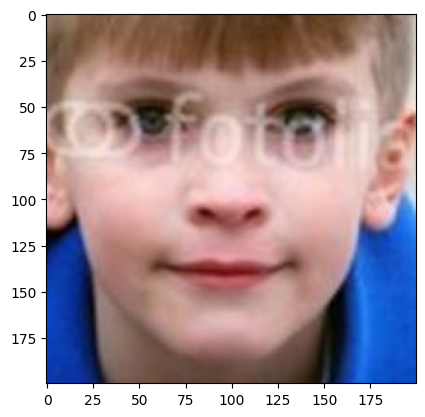

In [6]:
import matplotlib.pyplot as plt
plt.imshow(image_list[1000])
print(gender_list[1000])

In [7]:
print(image_list.shape)
print(gender_list.shape)

(7468, 200, 200, 3)
(7468,)


In [8]:
for i in range(len(image_list)):
    image_list[i]=image_list[i].astype('int64')

In [9]:
from sklearn.model_selection import train_test_split
X_train_gender,X_test_gender,Y_train_gender,Y_test_gender=train_test_split(image_list,gender_list,test_size=0.25,random_state=42)

In [10]:
del(image_list)

In [11]:
train_gen=ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True
)
test_gen=ImageDataGenerator(rescale=1./255)

In [12]:
batch_size=128
train_img=train_gen.flow(X_train_gender,Y_train_gender,
                         shuffle=True,
                         batch_size=batch_size)
test_img=test_gen.flow(X_test_gender,Y_test_gender,
                       shuffle=True,
                       batch_size=batch_size)

1


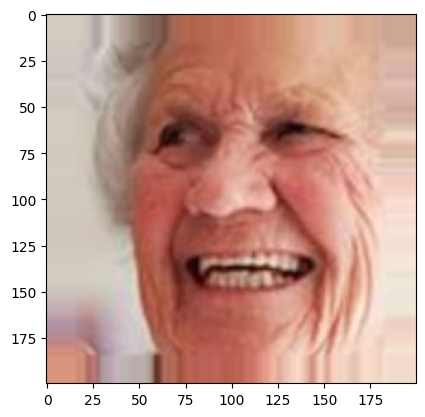

In [13]:
a=next(train_img)
plt.imshow(a[0][1])
print(a[1][1])

In [14]:
#gender prediction
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout,GlobalMaxPooling2D,MaxPooling2D,BatchNormalization
i=Input(shape=(X_train_gender.shape[1:]))
x=Conv2D(32,(3,3),activation='relu',padding='same')(i)
x=BatchNormalization()(x)
x=Conv2D(32,(3,3),activation='relu',padding='same')(x)
x=BatchNormalization()(x)
x=MaxPooling2D((2,2))(x)
x=Conv2D(64,(3,3),activation='relu',padding='same')(x)
x=BatchNormalization()(x)
x=Conv2D(64,(3,3),activation='relu',padding='same')(x)
x=BatchNormalization()(x)
x=MaxPooling2D((2,2))(x)
x=Conv2D(128,(3,3),activation='relu',padding='same')(x)
x=BatchNormalization()(x)
x=Conv2D(128,(3,3),activation='relu',padding='same')(x)
x=BatchNormalization()(x)
#x=MaxPooling2D((2,2))(x) #decrease test accuracy
x=GlobalMaxPooling2D()(x)
x=Flatten()(x)
x=Dropout(0.2)(x)
x=Dense(units=512,activation='relu')(x)
x=Dense(units=2,activation='softmax')(x)

model_gender=Model(i,x)

In [15]:
model_gender.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 200, 200, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 200, 200, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0     

In [16]:
#compiling model, categorical crossentropy is used as input labels are one-hot encoded
model_gender.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
batch_size=128
r=model_gender.fit(train_img,validation_data=test_img,
                      epochs=25,steps_per_epoch=int(np.ceil(len(X_train_gender)/batch_size)),
                      validation_steps=int(np.ceil(len(X_test_gender)/batch_size)))

Epoch 1/25
44/44 [==============================] - 79s 1s/step - loss: 0.9670 - accuracy: 0.5985 - val_loss: 0.6766 - val_accuracy: 0.5608
Epoch 2/25
44/44 [==============================] - 50s 1s/step - loss: 0.6341 - accuracy: 0.6490 - val_loss: 0.6815 - val_accuracy: 0.5619
Epoch 3/25
44/44 [==============================] - 50s 1s/step - loss: 0.6177 - accuracy: 0.6715 - val_loss: 0.6920 - val_accuracy: 0.5613
Epoch 4/25
44/44 [==============================] - 50s 1s/step - loss: 0.5906 - accuracy: 0.6786 - val_loss: 0.6813 - val_accuracy: 0.5560
Epoch 5/25
44/44 [==============================] - 50s 1s/step - loss: 0.5902 - accuracy: 0.6886 - val_loss: 0.7229 - val_accuracy: 0.4708
Epoch 6/25
44/44 [==============================] - 50s 1s/step - loss: 0.5621 - accuracy: 0.7065 - val_loss: 0.6791 - val_accuracy: 0.5731
Epoch 7/25
44/44 [==============================] - 51s 1s/step - loss: 0.5368 - accuracy: 0.7306 - val_loss: 0.6438 - val_accuracy: 0.6122
Epoch 8/25
44/44 [==

In [17]:
from tensorflow.keras.models import save_model
save_model(model_gender,'/kaggle/working/new3010.h5')

/tmp/ipykernel_25/1009119111.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_gender,'/kaggle/working/new3010.h5')


1


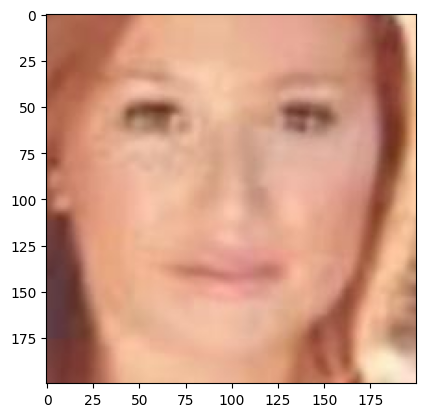

In [18]:
a=next(test_img)
plt.imshow(a[0][1])
print(a[1][1])

In [19]:
y_predicted=model_gender.predict(a[0]).argmax(axis=1)
y_original=a[1]

4/4 [==============================] - 2s 25ms/step


In [20]:
y_predicted

array([0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0])

<Axes: >

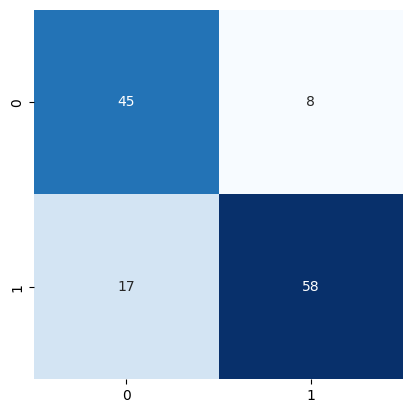

In [21]:
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(y_original,y_predicted)
import seaborn as sns
sns.heatmap(conf_mat,fmt='.0f',annot=True,cmap='Blues',cbar=False,square=True)

In [22]:
import cv2
img=cv2.imread('/kaggle/input/utkface-new/crop_part1/10_0_0_20170103200329407.jpg.chip.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(200,200),interpolation=cv2.INTER_CUBIC)
img=img[25:150,40:150]
img=cv2.resize(img,(200,200),interpolation=cv2.INTER_AREA)

In [23]:
img=img.astype('int64')

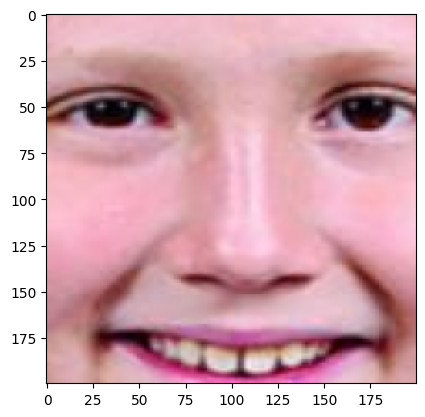

In [24]:
plt.imshow(img)
import numpy as np
img_test=np.expand_dims(img,axis=0)

In [25]:
pred=model_gender.predict(img_test).argmax(axis=1)

1/1 [==============================] - 0s 431ms/step


In [26]:
pred

array([0])